# 1. Import Dependencies

In [63]:
import numpy as np

import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from prophet import Prophet
from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdate

import pandas as pd
import requests

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr as PCC

from importlib import reload
import neural_network_classes, neural_network_functions
reload(neural_network_classes), reload(neural_network_functions)
from neural_network_classes import LSTM, DARNN, HARHN
from neural_network_functions import nn_train, nn_eval, nn_forecast

print("All libraries loaded")

All libraries loaded


# 2. Download Data

In [2]:
def download_data(url, name='', usecols=None, sheet_name=1, header=2, plot=False): 
    """
    This function downloads and extracts relevant data from downloadable XLS files embedded on eia.gov

    Args:
        url (str): link address of the EIA XLS file
        name (str, optional): Name of the data variable. Defaults to ''.
        usecols (str, optional): XLS columns to extract (e.g., 'A:B'). Defaults to None.
        sheet_name (int, optional): Sheet number of the XLS file that contains the data. Defaults to 1.
        header (int, optional): How many rows of the XLS file are header files. Defaults to 2.
        plot (bool, optional): Option to plot the data variable. Defaults to False.

    Returns:
        dict: dictionary containing data, number of data points/elements, range of dates, and the data variable name
    """
    global config
    
    r = requests.get(url)
    open('temp.xls', 'wb').write(r.content)
    df = pd.read_excel('temp.xls', sheet_name=sheet_name, header=header, usecols=usecols) 
    df = df[~df.isnull().any(axis=1)] # remove rows with any missing data
       
    num_data_points = len(df)
    
    df2 = df.iloc[[0, -1]]    
    date_range = "from " + str(df2.iloc[0,0]) + " to " + str(df2.iloc[1,0])
    print(date_range, str(num_data_points) + ' Data Points')
    
    data_dict = {}
    data_dict['data'] = df.rename(columns={df.keys()[0]: 'date', 
                            df.keys()[1]: name})
    data_dict['num elements'] = num_data_points
    data_dict['date range'] = date_range
    data_dict['name'] = df.keys()[1]
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_dict['data']['date'], data_dict['data'][name], color=config["plots"]["color_actual"])
        plt.title(data_dict['name'] + ", " + data_dict['date range'] + ", " + str(data_dict['num elements']) + " Data Points")

        # Format the x axis
        locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
        fmt = mdate.DateFormatter('%Y-%m')
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)
        plt.xticks(rotation='vertical')
        plt.xlim([data_dict['data'].iloc[0,0], data_dict['data'].iloc[-1,0]])

        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()
         
    return data_dict

In [3]:
plot = False

## 2a. Seattle Gas Prices (targets)

In [4]:
seattle_gas_prices = download_data('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMRU_PTE_Y48SE_DPGw.xls', 
                                   name='gas price',
                                  plot=plot)

print(seattle_gas_prices['data'].head())

from 2003-05-26 00:00:00 to 2022-07-11 00:00:00 999 Data Points
        date  gas price
0 2003-05-26      1.534
1 2003-06-02      1.524
2 2003-06-09      1.522
3 2003-06-16      1.578
4 2003-06-23      1.580


## 2b. U.S. Crude Oil Stock Change (feature 1)

In [5]:
us_oil_stock = download_data('https://www.eia.gov/dnav/pet/hist_xls/MCRSCUS1m.xls',
                             name='oil stock exchange',
                             plot=plot)

print(us_oil_stock['data'].head())

from 1981-01-15 00:00:00 to 2022-04-15 00:00:00 496 Data Points
        date  oil stock exchange
0 1981-01-15               -1535
1 1981-02-15                7773
2 1981-03-15               19596
3 1981-04-15               17853
4 1981-05-15               12109


## 2c. U.S. Natural Gas Rotary Rigs in Operation (feature 2)

In [6]:
us_drilling_activity = download_data('https://www.eia.gov/dnav/pet/hist_xls/E_ERTRRG_XR0_NUS_Cm.xls',
                             name='drilling activity',
                             plot=plot)

print(us_drilling_activity['data'].head())

from 1987-08-15 00:00:00 to 2022-03-15 00:00:00 416 Data Points
          date  drilling activity
175 1987-08-15              352.0
176 1987-09-15              364.0
177 1987-10-15              377.0
178 1987-11-15              386.0
179 1987-12-15              403.0


## 2d. U.S. Natural Gas Production (feature 3)

In [7]:
us_gas_production = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9050US2m.xls',
                             name='gas production',
                             plot=plot)

print(us_gas_production['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas production
0 1973-01-15         1948000
1 1973-02-15         1962000
2 1973-03-15         1907000
3 1973-04-15         1814000
4 1973-05-15         1898000


## 2e. U.S. Natural Gas Consumption (feature 4)

In [8]:
us_gas_consumption = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9140US2m.xls',
                             name='gas consumption',
                             plot=plot)

print(us_gas_consumption['data'].head())

from 2001-01-15 00:00:00 to 2022-04-15 00:00:00 256 Data Points
        date  gas consumption
0 2001-01-15          2676998
1 2001-02-15          2309464
2 2001-03-15          2246633
3 2001-04-15          1807170
4 2001-05-15          1522382


## 2f. Underground Natural Gas Storage Capacity (feature 5)

In [9]:
us_gas_storage = download_data('https://www.eia.gov/dnav/ng/xls/NG_STOR_CAP_DCU_NUS_M.xls',
                             name='gas storage',
                               usecols='A:B',
                             plot=plot)

print(us_gas_storage['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas storage
0 1989-01-15      8119368
1 1989-02-15      8119368
2 1989-03-15      8119368
3 1989-04-15      8119368
4 1989-05-15      8119368


## 2g. U.S. Natural Gas Import Volumes (feature 6)

In [10]:
us_gas_import_volume = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import volume',
                               usecols='A:B',
                               sheet_name=1,
                             plot=plot)

print(us_gas_import_volume['data'].tail())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
          date  gas import volume
587 2021-12-15             252626
588 2022-01-15             296179
589 2022-02-15             259389
590 2022-03-15             260642
591 2022-04-15             246576


## 2g. U.S. Natural Gas Import Prices (feature 7)

In [11]:
us_gas_import_price = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import price',
                               usecols='A:B',
                               sheet_name=2,
                             plot=plot)

print(us_gas_import_price['data'].tail())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
          date  gas import price
395 2021-12-15              4.74
396 2022-01-15              6.87
397 2022-02-15              5.62
398 2022-03-15              4.67
399 2022-04-15              5.46


## 2h. Henry Hub Natural Gas Spot Price (feature 8)

In [12]:
hh_natural_gas_price = download_data('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls',
                             name='natural gas price',
                             plot=plot)

print(hh_natural_gas_price['data'].head())

from 1997-01-15 00:00:00 to 2022-06-15 00:00:00 306 Data Points
        date  natural gas price
0 1997-01-15               3.45
1 1997-02-15               2.15
2 1997-03-15               1.89
3 1997-04-15               2.03
4 1997-05-15               2.25


## 2i. Crude Oil Spot Price (feature 9)

In [13]:
us_crude_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='crude oil price',
                                   usecols='A:B',
                                   sheet_name=1, 
                                   plot=plot)

print(us_crude_oil_price['data'].head())

from 1986-01-15 00:00:00 to 2022-06-15 00:00:00 438 Data Points
        date  crude oil price
0 1986-01-15            22.93
1 1986-02-15            15.46
2 1986-03-15            12.61
3 1986-04-15            12.84
4 1986-05-15            15.38


## 2j. Conventional Gasoline Price (feature 10)

In [14]:
us_gas_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='conventional gas price',
                                   usecols='A:B',
                                   sheet_name=2, 
                                   plot=plot)

print(us_gas_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  conventional gas price
0 1986-06-15                   0.420
1 1986-07-15                   0.340
2 1986-08-15                   0.426
3 1986-09-15                   0.420
4 1986-10-15                   0.410


## 2k. RBOB Gasoline Price (feature 11)

In [15]:
us_rbob_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='rbob gas price',
                                   usecols='A:B',
                                   sheet_name=3, 
                                   plot=plot)

print(us_rbob_price['data'].head())

from 2003-06-15 00:00:00 to 2022-06-15 00:00:00 229 Data Points
        date  rbob gas price
0 2003-06-15           1.072
1 2003-07-15           0.965
2 2003-08-15           1.315
3 2003-09-15           0.949
4 2003-10-15           0.996


## 2l. Heating Oil Price (feature 12)

In [16]:
us_heating_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='heating oil price',
                                   usecols='A:B',
                                   sheet_name=4, 
                                   plot=plot)

print(us_heating_oil_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  heating oil price
0 1986-06-15              0.380
1 1986-07-15              0.334
2 1986-08-15              0.408
3 1986-09-15              0.402
4 1986-10-15              0.394


## 2m. Diesel Price (feature 13)

In [17]:
us_diesel_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='diesel price',
                                   usecols='A:B',
                                   sheet_name=5, 
                                   plot=plot)

print(us_diesel_price['data'].head())

from 2006-06-15 00:00:00 to 2022-06-15 00:00:00 193 Data Points
          date  diesel price
122 2006-06-15         2.091
123 2006-07-15         2.217
124 2006-08-15         2.247
125 2006-09-15         1.810
126 2006-10-15         1.794


## 2n. Kerosene Price (feature 14)

In [18]:
us_kerosene_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='kerosene price',
                                   usecols='A:B',
                                   sheet_name=6, 
                                   plot=plot)

print(us_kerosene_price['data'].tail())

from 1990-04-15 00:00:00 to 2022-06-15 00:00:00 387 Data Points
          date  kerosene price
382 2022-02-15           2.682
383 2022-03-15           3.495
384 2022-04-15           3.914
385 2022-05-15           3.902
386 2022-06-15           4.120


## 2o. Propane Price (feature 15)

In [19]:
us_propane_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='propane price',
                                   usecols='A:B',
                                   sheet_name=7, 
                                   plot=plot)

print(us_propane_price['data'].tail())

from 1992-06-15 00:00:00 to 2022-06-15 00:00:00 361 Data Points
          date  propane price
356 2022-02-15          1.283
357 2022-03-15          1.448
358 2022-04-15          1.302
359 2022-05-15          1.223
360 2022-06-15          1.219


# 3. Combine Feature and Target Data

In [20]:
# features
feature_list = [
    hh_natural_gas_price['data'],
    us_crude_oil_price['data'],
    us_gas_price['data'],
    us_rbob_price['data'],
    us_heating_oil_price['data'],
    us_diesel_price['data'],
    us_kerosene_price['data'],
    us_propane_price['data'],
    us_oil_stock['data'],
    us_drilling_activity['data'],
    us_gas_production['data'],
    us_gas_consumption['data'],
    us_gas_storage['data'],
    us_gas_import_volume['data'],
    us_gas_import_price['data']
]

# targets
targets = seattle_gas_prices['data'].set_index('date')

In [21]:
# reindex and concatenate features
kw = dict(method="time") # method to interpolate feature data to target date indices 
for i in range(0, len(feature_list)):
    if i > 1:
        feature = feature_list[i].set_index('date')
        feature = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index) # resample to target date indices
        features = features.join(feature)
    else:
        feature = pd.DataFrame(feature_list[i]).set_index('date') # initiate dataframe on first loop iteration
        features = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)  # resample to target date indices

# add week number (1-52) as a feature
features['week number'] = features.index.isocalendar().week
features['week number'] = features['week number'].astype(float)
    
# combine features and targets into one data frame
features_targets = features.join(targets)

# get rid of rows with any missing data
features_targets = features_targets[~features_targets.isnull().any(axis=1)]

# convert index datetimes to dates (exclude hour, minute, second)
features_targets.index = features_targets.index.date
features_targets

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,gas consumption,gas storage,gas import volume,gas import price,week number,gas price
2006-06-19,71.411333,2.087933,2.412600,1.926333,2.107800,2.090733,1.106067,-4598.933333,1376.400000,1.618895e+06,1.578593e+06,8.247523e+06,351139.000000,5.846000,25.0,3.067
2006-06-26,72.218667,2.128067,2.432900,1.928667,2.137200,2.107767,1.121933,-4744.066667,1377.100000,1.627353e+06,1.627092e+06,8.249157e+06,356466.000000,5.874000,26.0,3.027
2006-07-03,73.026000,2.168200,2.453200,1.931000,2.166600,2.124800,1.137800,-4889.200000,1377.800000,1.635812e+06,1.675591e+06,8.250790e+06,361793.000000,5.902000,27.0,3.004
2006-07-10,73.833333,2.208333,2.473500,1.933333,2.196000,2.141833,1.153667,-5034.333333,1378.500000,1.644271e+06,1.724091e+06,8.252423e+06,367120.000000,5.930000,28.0,3.032
2006-07-17,74.321613,2.224161,2.468774,1.938161,2.218935,2.152645,1.163258,-4727.161290,1381.451613,1.650682e+06,1.758278e+06,8.253590e+06,370540.935484,6.000968,29.0,3.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,114.498710,4.065613,4.254774,4.262194,4.380323,4.105935,1.219258,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,24.0,5.549
2022-06-20,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,25.0,5.518
2022-06-27,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,26.0,5.461
2022-07-04,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,27.0,5.405


# 4. Data Preprocessing

## 4a. Incorporate Rolling Lookback Window

In [22]:
data = features_targets
target_name = 'gas price' # target variable name
feature_names = features_targets.columns[0:-1].tolist() # exclude the last column aka the target variable

timesteps = 8 # rolling lookback window length

# Preallocate feature and target arrays
X_ = np.zeros((len(data), timesteps, data.shape[1]-1))
y_ = np.zeros((len(data), timesteps, 1))

In [23]:
# Include rolling lookback window sequences in feature array
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X_[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [24]:
# Include rolling lookback window sequences in target history array
for j in range(timesteps):
    y_[:, j, 0] = data[target_name].shift(timesteps - j - 1).fillna(method="bfill")

In [25]:
prediction_horizon = 1 # how far to train the neural nets to predict into the future 
target_ = data[target_name].shift(-prediction_horizon).fillna(method="ffill").values # shift target values 'prediction_horizon' times into the future 

## 4b. Build Training, Validation, and Testing Datasets

In [26]:
# Dataset indices
up_to_train_idx = int(data.shape[0]*0.70)
up_to_val_idx = int(data.shape[0]*0.85)

# Number of data points in each dataset
train_length = up_to_train_idx
val_length = up_to_val_idx - up_to_train_idx
test_length = data.shape[0] - train_length - val_length

print(train_length, val_length, test_length)

587 126 126


In [27]:
# Exclude data points that don't have rolling window sequences
X = X_[timesteps:]
y = y_[timesteps:]
target = target_[timesteps:]

In [28]:
# Split into train-val-test datasets
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

## 4c. Normalize Data

In [29]:
class Normalizer():
    def __init__(self):
        self.max = None
        self.min = None
        self.range = None

    def fit_transform(self, x):
        """
        This function computes the max, min and range of values from the training dataset
        These values will be used to normalize the training, validation, and testing datasets
        This function returns the normalized training dataset (values fall within [0:1])

        Args:
            x (numpy array): training data

        Returns:
            numpy array: _description_
        """
        self.max = x.max(axis=0)
        self.min = x.min(axis=0)
        self.range = self.max - self.min
        normalized_x = (x - self.min)/self.range
        return normalized_x
    
    def transform(self, x):
        """
        This function performs a normalization of the input dataset

        Args:
            x (numpy array): dataset that is being normalized based on the class instances 

        Returns:
            numpy array: normalized dataset
        """
        return (x - self.min)/self.range

    def inverse_transform(self, x):
        """
        This function performs a de-normalization of the input dataset

        Args:
            x (numpy array): dataset that is being de-normalized based on the class instances

        Returns:
            numpy array: de-normalized dataset
        """
        return (x*self.range) + self.min

In [30]:
# Create normalizer class objects
x_scaler = Normalizer()
y_his_scaler = Normalizer()
target_scaler = Normalizer()

In [31]:
# Normalize features
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

# Normalize target histories
y_his_train = y_his_scaler.fit_transform(y_his_train)
y_his_val = y_his_scaler.transform(y_his_val)
y_his_test = y_his_scaler.transform(y_his_test)

# Normalize target data
target_train = target_scaler.fit_transform(target_train)
target_val = target_scaler.transform(target_val)
target_test = target_scaler.transform(target_test)

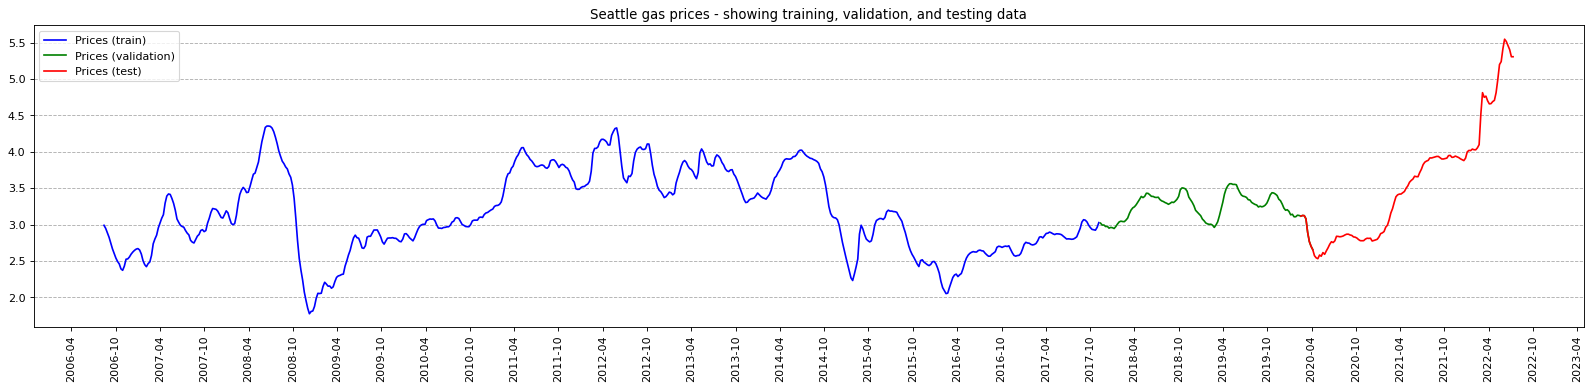

In [32]:
## Prepare data for plotting
data_date = features_targets.index.tolist()[timesteps:]
num_data_points = len(y)

# pre-allocate
to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)
to_plot_data_y_test = np.zeros(num_data_points)

# de-normalize targets for the purposes of plotting
to_plot_data_y_train[:train_length] = target_scaler.inverse_transform(target_train)
to_plot_data_y_val[train_length:train_length+val_length] = target_scaler.inverse_transform(target_val)
to_plot_data_y_test[-val_length:] = target_scaler.inverse_transform(target_test)

# Replace 0's with None
to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## Plotting
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color='blue')
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color='green')
plt.plot(data_date, to_plot_data_y_test, label="Prices (test)", color='red')

# Format the x axis
locator = mdate.MonthLocator(interval=6)
fmt = mdate.DateFormatter('%Y-%m')
X = plt.gca().xaxis
X.set_major_locator(locator) # error
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation='vertical')

plt.title("Seattle gas prices - showing training, validation, and testing data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## 4d. Build Torch Data Loaders

In [33]:
# Build Datasets
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [34]:
batch_size = 32

# Build PyTorch DataLoaders
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

# 5. Modeling

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # training device
n_timeseries = data.shape[1] - 1 # input size
max_epochs = 250

# LSTM architecture hyperparameters 
lstm_n_hidden = 64
lstm_n_layers = 2

# DA-RNN architecture hyperparameters
darnn_n_enc_units = 64
darnn_n_dec_units = 64 # 64

# HRHN architecture hyperparameters
harhn_n_enc_units = 64
harhn_n_dec_units = 64

## 5a. Facebook Prophet

### Training

In [36]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False) # Prophet model likes columns labeled as 'ds' for time indices and 'y' for variable data

n = NeuralProphet() # initialize data
df_train, df_test = n.split_df(df=df, freq="W", valid_p=0.15) # split data

params = {
    "changepoint_prior_scale": 0.25, # limit of trend change magnitudes at change points
    "changepoint_range": 0.90, # limit of when to stop fitting change points
    "interval_width": 0.95 # The width of the uncertainty intervals
}

# Train
m = Prophet(**params)
metrics =  m.fit(df_train)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
13:23:31 - cmdstanpy - INFO - Chain [1] start processing
13:23:32 - cmdstanpy - INFO - Chain [1] done processing


### Evaluation

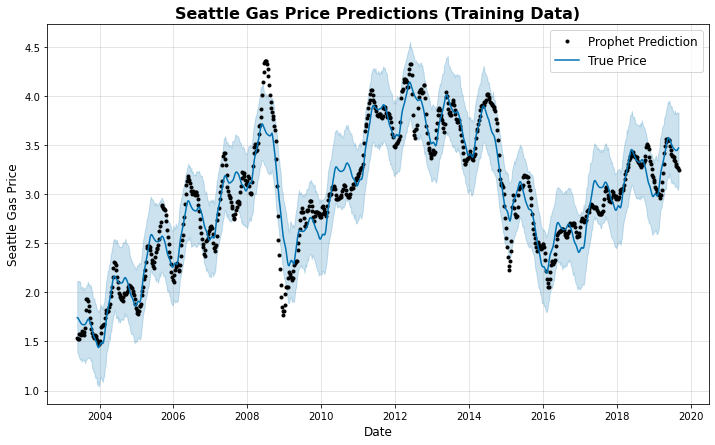

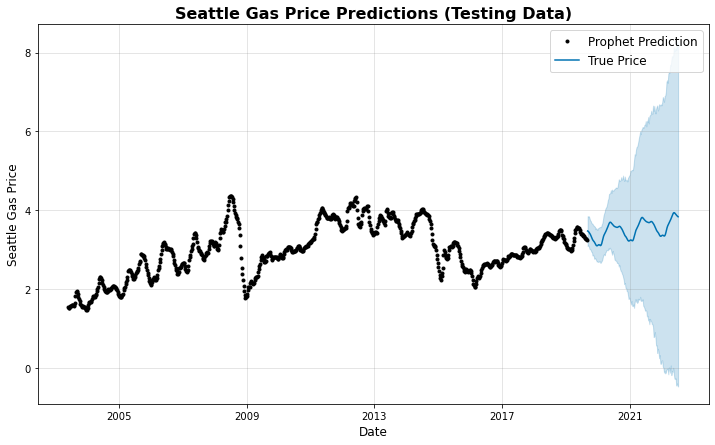

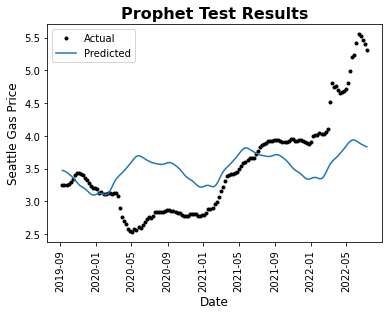

[0.42294241364464746, 0.5174360787890214, 0.22025914540502822, 0.5181583693643318]


In [37]:
# training data
train_pred = m.predict(df_train)

fig1 = m.plot(train_pred)
ax = fig1.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Training Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Prophet Prediction', 'True Price'], fontsize=12)

# testing data
eval_pred = m.predict(df_test)

fig2 = m.plot(eval_pred)
ax = fig2.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Testing Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Prophet Prediction', 'True Price'], fontsize=12)

fig3 = plt.figure()
y_true= df_test['y'].values
y_pred = eval_pred['yhat'].values
plt.plot(df_test['ds'], y_true, label='Actual', marker='.', linestyle='', color='k')
plt.plot(df_test['ds'], y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Prophet Test Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.show()

# metrics
prophet_mse = mean_squared_error(y_true, y_pred)
prophet_mae = mean_absolute_error(y_true, y_pred)
prophet_r2 = r2_score(y_true, y_pred)
prophet_pcc = PCC(y_true, y_pred)[0]

print([prophet_mse, prophet_mae, prophet_r2, prophet_pcc])

### Forecasting

13:23:38 - cmdstanpy - INFO - Chain [1] start processing
13:23:40 - cmdstanpy - INFO - Chain [1] done processing


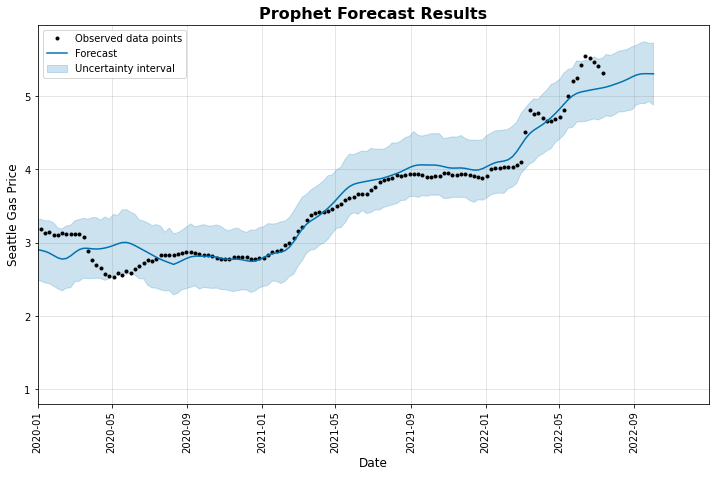

In [38]:
# Re-fit to all data
m = Prophet(**params)
metrics =  m.fit(df)

# Forecast
future = m.make_future_dataframe(periods=12, freq='W', include_history=True)
forecast = m.predict(future)

fig4 = m.plot(forecast)
ax = fig4.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2020-01-01', '2022-12-31'])) 
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Prophet Forecast Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

## 5b. Facebook Neural Prophet

### Training

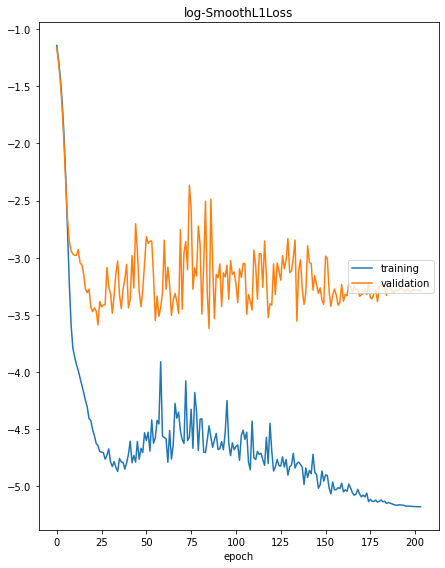

log-SmoothL1Loss
	training         	 (min:   -5.177, max:   -1.145, cur:   -5.177)
	validation       	 (min:   -3.620, max:   -1.163, cur:   -3.287)


In [39]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False) # same data format as Prophet

# https://rdrr.io/github/AlbertoAlmuinha/neuralprophet/man/neural_prophet.html
params = {
    "changepoints_range": 0.90,  # limit of when to stop fitting change points
}

model = NeuralProphet(**params) # initialize model

df_train, df_test = model.split_df(df=df, freq="W", valid_p=0.15) # split datasets

metrics =  model.fit(df_train, freq="W", validation_df=df_test, progress="plot")

### Evaluation

In [40]:
test_pred = model.predict(df_test)
test_metrics = model.test(df_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.037  0.571  0.693


INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.882% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.882% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


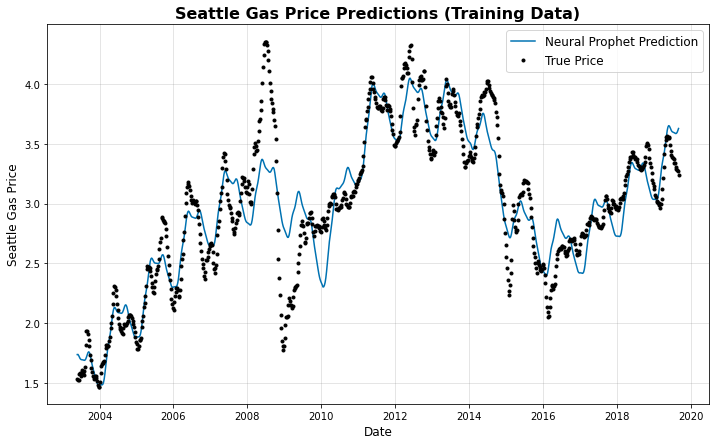

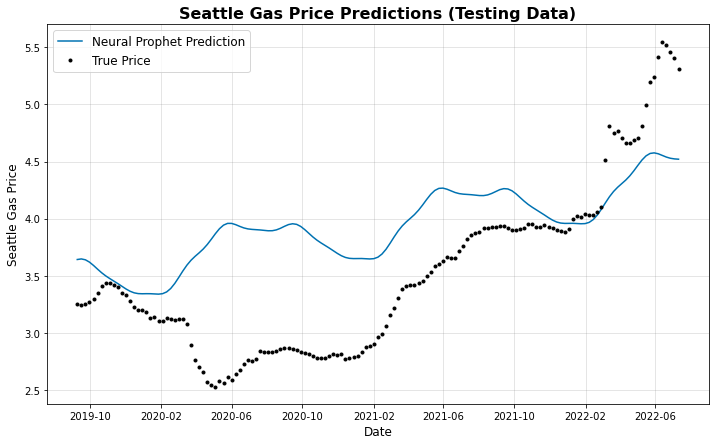

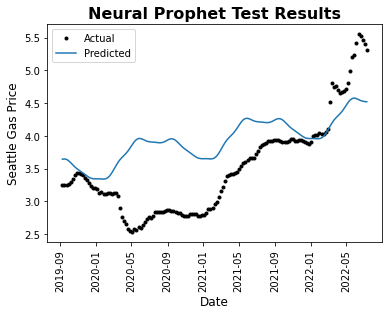

[0.48057934340469183, 0.5714939655841598, 0.11399912650541721, 0.7182192771066777]


In [41]:
# training data
fig1 = model.plot(model.predict(df_train))
ax = fig1.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Training Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Neural Prophet Prediction', 'True Price'], fontsize=12)

# testing data
eval_pred = model.predict(df_test)

fig2 = model.plot(eval_pred)
ax = fig2.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Testing Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Neural Prophet Prediction', 'True Price'], fontsize=12)

fig3 = plt.figure()
y_true = test_pred['y'].values
y_pred = test_pred['yhat1'].values
plt.plot(df_test['ds'], y_true, label='Actual', marker='.', linestyle='', color='k')
plt.plot(df_test['ds'], y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Neural Prophet Test Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.show()

# metrics
nprophet_mse = mean_squared_error(y_true, y_pred)
nprophet_mae = mean_absolute_error(y_true, y_pred)
nprophet_r2 = r2_score(y_true, y_pred)
nprophet_pcc = PCC(y_true, y_pred)[0]

print([nprophet_mse, nprophet_mae, nprophet_r2, nprophet_pcc])

### Forecasting

In [42]:
# retrain with all available data
model2 = NeuralProphet(**params)
metrics_train2 = model2.fit(df=df, freq="W")

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 194


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.79E-02, min: 9.64E-01


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.02E-02, min: 1.58E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.17E-02
Epoch[194/194]: 100%|██████████| 194/194 [00:28<00:00,  6.91it/s, SmoothL1Loss=0.00778, MAE=0.234, RMSE=0.315, RegLoss=0]


In [44]:
# forecast
future = model2.make_future_dataframe(df, periods=12, n_historic_predictions=96)
forecast = model2.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - c:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - c:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: T

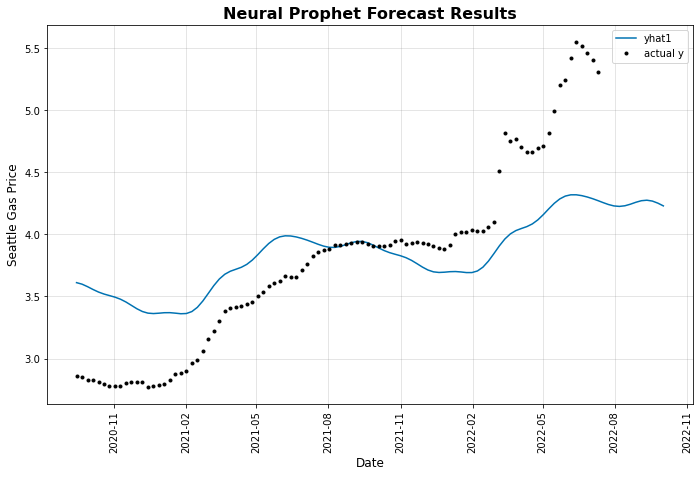

In [45]:
fig = model2.plot(forecast)
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2020-01-01', '2022-12-31'])) 
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Neural Prophet Forecast Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

## 5c. Neural Network (LSTM)

### Training

In [46]:
lstm = LSTM(num_classes=1, input_size=n_timeseries+1, hidden_size=lstm_n_hidden, num_layers=lstm_n_layers,
             seq_length=timesteps, device=device, dropout=0.2)
model_name = 'lstm'
lstm_opt = optim.AdamW(lstm.parameters(), lr=0.01) # optimizer
lstm_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=lstm_opt, patience=15) # learing rate scheduler

Validation loss decreased (inf --> 1.064517).  Saving model ...
Iter:  0 train:  1.7180146510856624 val:  0.47340130956713594 LR:  0.01
mse:  0.22512206 mae:  0.46055543


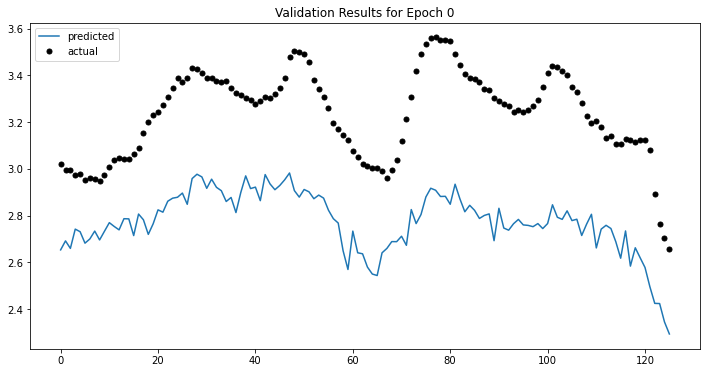

Validation loss decreased (1.064517 --> 0.237429).  Saving model ...
Iter:  1 train:  0.660811680694789 val:  0.22357323356380102 LR:  0.01
Validation loss decreased (0.237429 --> 0.231132).  Saving model ...
Iter:  2 train:  0.407798350168355 val:  0.22058867683937894 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  3 train:  0.3410510802240476 val:  0.24296326451122016 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  4 train:  0.279887842817108 val:  0.2540370557891327 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  5 train:  0.27632319548262707 val:  0.23576800493148153 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  6 train:  0.2719063772709572 val:  0.22892484197974214 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  7 train:  0.2867126440909065 val:  0.2260857822296455 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  8 train:  0.2587331111235292 val:  0.26288000214971924 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  9 train:  0.22972141184427303 val:  0.

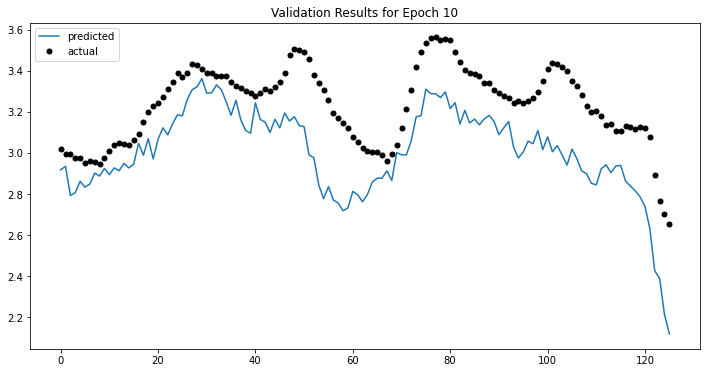

EarlyStopping counter: 9 out of 50
Iter:  11 train:  0.24036843350854648 val:  0.236430513089175 LR:  0.01
Validation loss decreased (0.231132 --> 0.214935).  Saving model ...
Iter:  12 train:  0.2260848613942879 val:  0.21271919576203796 LR:  0.01
Validation loss decreased (0.214935 --> 0.184129).  Saving model ...
Iter:  13 train:  0.24966148272677235 val:  0.19688584065607453 LR:  0.01
Validation loss decreased (0.184129 --> 0.145350).  Saving model ...
Iter:  14 train:  0.22535209208890053 val:  0.17492842984319 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  15 train:  0.22037457334640795 val:  0.18886466543944677 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  16 train:  0.2056837163723174 val:  0.20594713973122164 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  17 train:  0.2003169051642149 val:  0.20525275040251068 LR:  0.01
Validation loss decreased (0.145350 --> 0.106354).  Saving model ...
Iter:  18 train:  0.2118659522450372 val:  0.14963397438071974 LR:  0.01
E

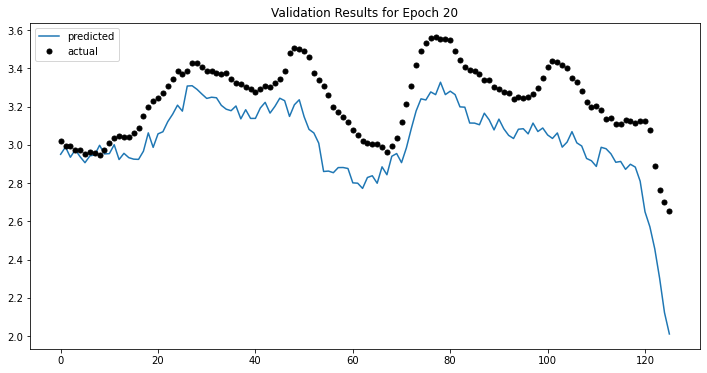

EarlyStopping counter: 3 out of 50
Iter:  21 train:  0.19306352644144747 val:  0.24002292290134405 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  22 train:  0.1781611391231117 val:  0.23770139384779182 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  23 train:  0.17726056874798424 val:  0.19393147979149078 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  24 train:  0.17188508989323945 val:  0.16367221782405483 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  25 train:  0.1706641562872161 val:  0.20465437819207877 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  26 train:  0.20577106310249546 val:  0.24989860056253327 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  27 train:  0.20881613740938895 val:  0.1865267460293903 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  28 train:  0.1771788672707163 val:  0.17264143643352356 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  29 train:  0.16156704419763968 val:  0.1749566602863758 LR:  0.01
EarlyStopping counter:

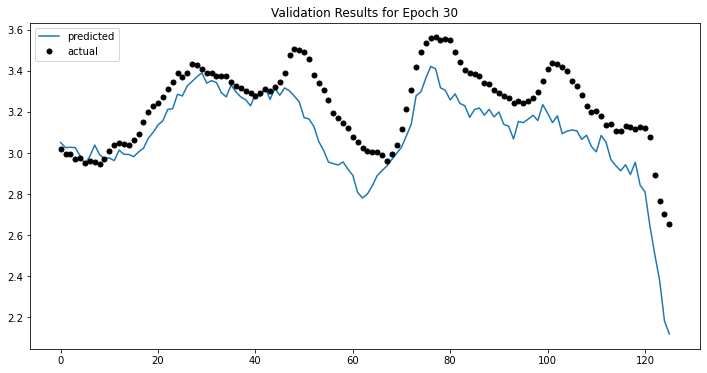

EarlyStopping counter: 13 out of 50
Iter:  31 train:  0.1742728028415908 val:  0.20733040922550972 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  32 train:  0.16028908198830227 val:  0.17258046045491104 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  33 train:  0.1723648739672635 val:  0.2186488304358978 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  34 train:  0.18217538716463524 val:  0.17563312351638066 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  35 train:  0.14674586092420652 val:  0.18528683502084292 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  36 train:  0.13898532763780566 val:  0.166777301099666 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  37 train:  0.14596026942883175 val:  0.17936961116204136 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  38 train:  0.14036366260263283 val:  0.18337140390547946 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  39 train:  0.13587284586376494 val:  0.17882394303429425 LR:  0.001
EarlyStop

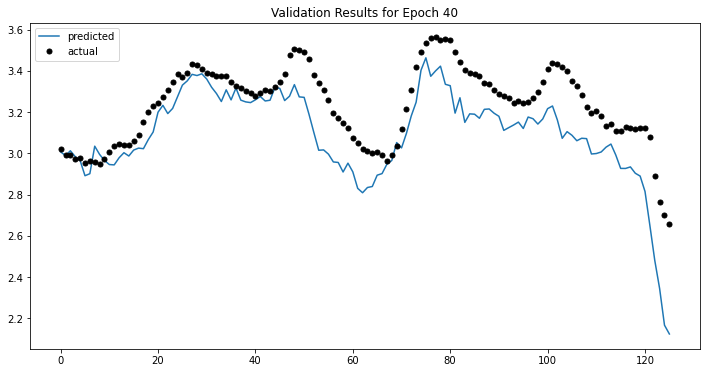

EarlyStopping counter: 23 out of 50
Iter:  41 train:  0.14167207633071638 val:  0.16882209038511195 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  42 train:  0.13596267858045818 val:  0.16722790568272192 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  43 train:  0.13458494818627081 val:  0.16154521841896788 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  44 train:  0.1328976865969442 val:  0.1844735535960684 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  45 train:  0.13261599748730418 val:  0.17853767673326165 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  46 train:  0.13223236629138838 val:  0.18133331888476742 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  47 train:  0.13278210929537196 val:  0.16476902302761853 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  48 train:  0.13536013369340896 val:  0.17771333334932632 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  49 train:  0.13649377218282713 val:  0.1798153647097992 LR:  0.001
Earl

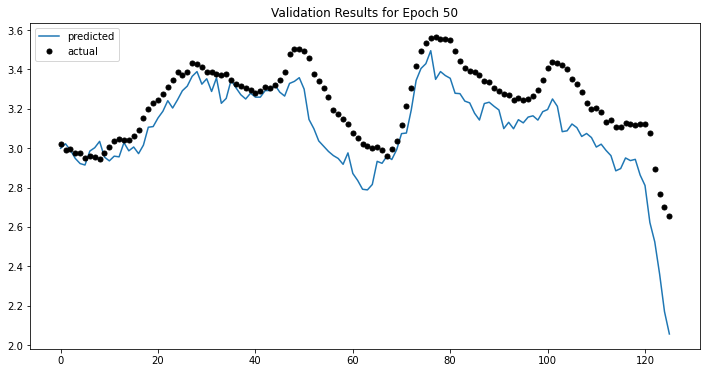

EarlyStopping counter: 33 out of 50
Iter:  51 train:  0.12532950333065193 val:  0.16749333181091022 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  52 train:  0.13444923035827597 val:  0.17211484088489457 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  53 train:  0.12978214085444367 val:  0.16770165386498512 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  54 train:  0.12749351217933938 val:  0.16515359791979425 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  55 train:  0.12718791849772026 val:  0.16871704502235088 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  56 train:  0.1282368267210698 val:  0.16921043309374809 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  57 train:  0.13054427096982207 val:  0.17169047390804384 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  58 train:  0.12728101303063444 val:  0.17344625754107504 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  59 train:  0.12973915242840725 val:  0.17199380689217217 LR:  

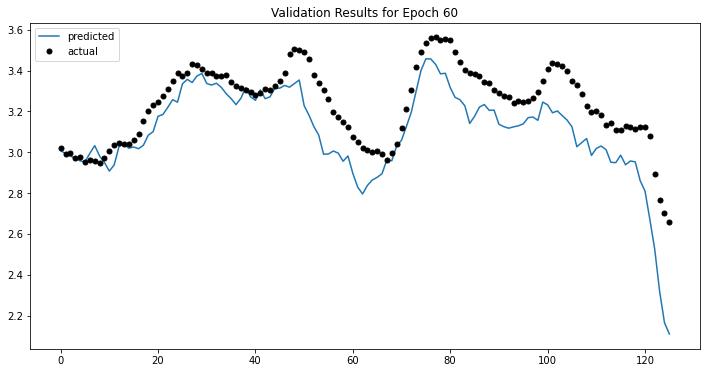

EarlyStopping counter: 43 out of 50
Iter:  61 train:  0.13276811369559813 val:  0.17268558772139153 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  62 train:  0.12592375162504418 val:  0.17508748718360548 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  63 train:  0.13082762881972887 val:  0.17617429103256377 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  64 train:  0.12996435970128295 val:  0.1661456744308081 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  65 train:  0.12807377512130727 val:  0.17324244857331103 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  66 train:  0.12718068721579112 val:  0.16993888480221692 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  67 train:  0.12506991675510903 val:  0.17201416727475285 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [47]:
nn_train(model=lstm, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=lstm_opt, 
         scheduler=lstm_scheduler,
         target_scaler=target_scaler,
         device=device,
         plot=True)

### Evaluation

In [48]:
# Load best-performing model
lstm.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

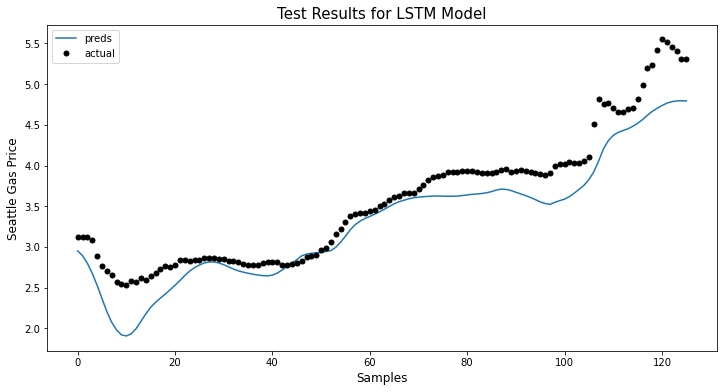

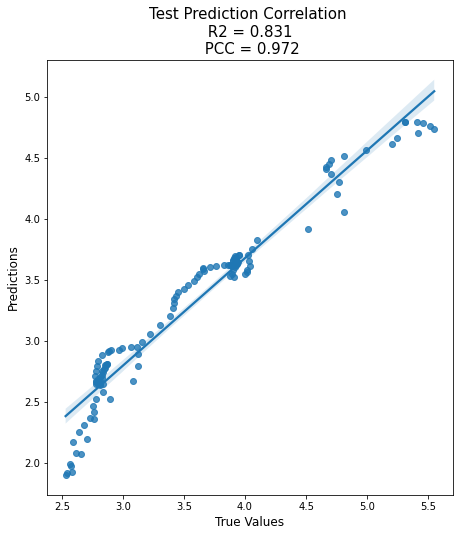

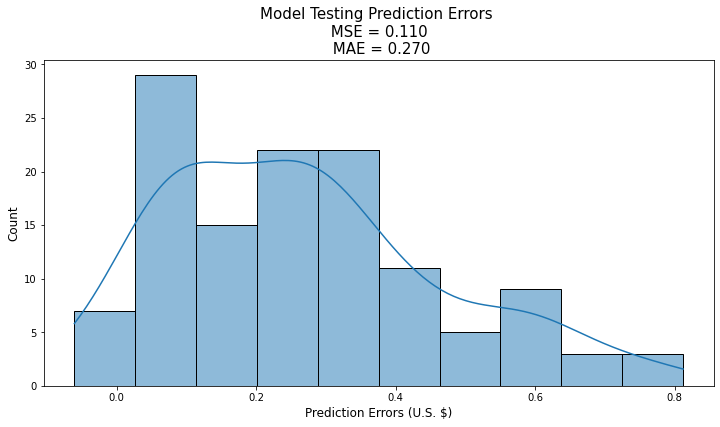

In [64]:
lstm_mse, lstm_mae, lstm_r2, lstm_pcc, lstm_preds, lstm_true, _, _ = nn_eval(model=lstm, 
                                                                             model_name='lstm', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler, 
                                                                             device=device, 
                                                                             cols=feature_names
                                                                             )

### Forecasting

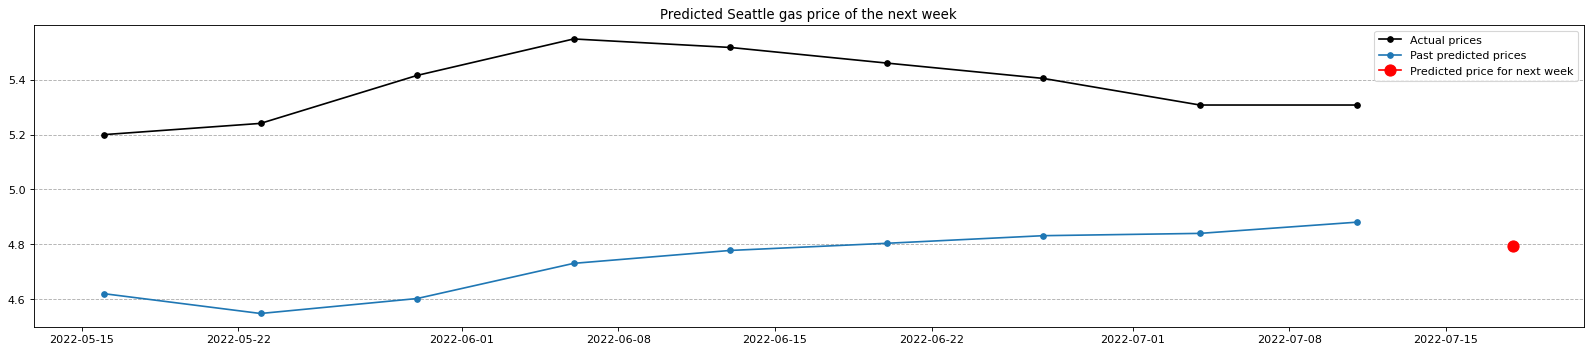

LSTM Predicted Seattle Gas Price of the next week: $4.79


In [50]:
nn_forecast(model = lstm,
            model_name = 'lstm', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = lstm_true, 
            preds = lstm_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler,
            device=device, 
            dates=data_date,
            plot_range=10
           )

## 5d. Dual-Stage Attention-Based Recurrent Neural Network (DA-RNN)

### Training

In [51]:
darnn = DARNN(N=X_train.shape[2], M=darnn_n_enc_units, P=darnn_n_dec_units,
              T=X_train.shape[1], device=device).to(device) 
model_name = 'darnn'
darnn_opt = optim.AdamW(darnn.parameters(), lr=0.01) # optimizer
darnn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=darnn_opt, patience=15) # learning rate scheduler 

Validation loss decreased (inf --> 0.670631).  Saving model ...
Iter:  0 train:  1.7074155613793376 val:  0.3757466088212686 LR:  0.01
mse:  0.14182381 mae:  0.337516


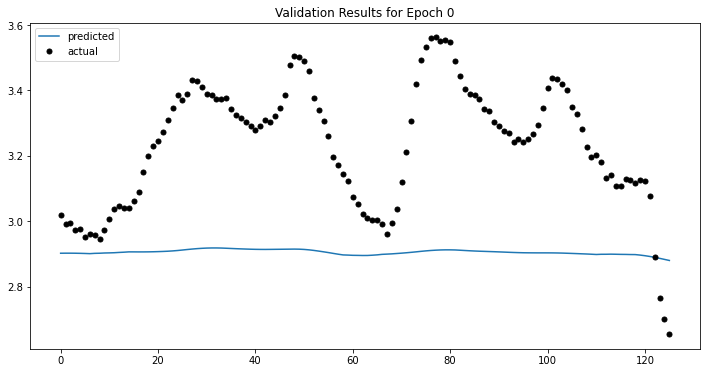

Validation loss decreased (0.670631 --> 0.341967).  Saving model ...
Iter:  1 train:  1.1155087969963502 val:  0.2683151976925527 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  2 train:  0.53358848356077 val:  0.3286890136701725 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  3 train:  0.3611247753447629 val:  0.4256234961217133 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  4 train:  0.3410513939718089 val:  0.37947169227702626 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  5 train:  0.30960186998238626 val:  0.3838936359413752 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  6 train:  0.2815278739239526 val:  0.345869577803453 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  7 train:  0.2723354712272308 val:  0.3118185650894148 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  8 train:  0.2712959151823403 val:  0.30071527464123976 LR:  0.01
Validation loss decreased (0.341967 --> 0.339789).  Saving model ...
Iter:  9 train:  0.22950224983832346 val:  0.2674

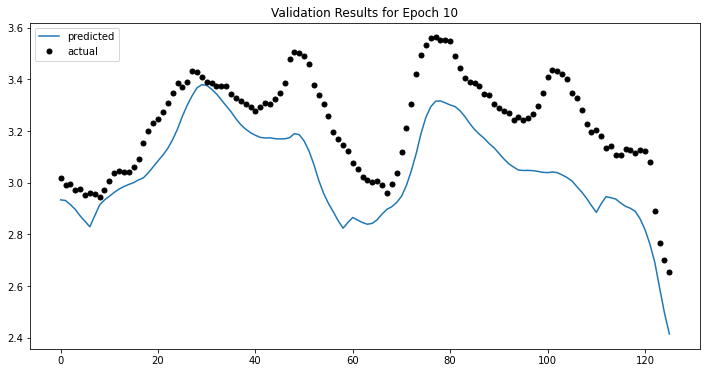

Validation loss decreased (0.214778 --> 0.153924).  Saving model ...
Iter:  11 train:  0.2074713557602439 val:  0.1800139925976394 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  12 train:  0.17869766510814736 val:  0.20518767005332936 LR:  0.01
Validation loss decreased (0.153924 --> 0.112228).  Saving model ...
Iter:  13 train:  0.16509223764894415 val:  0.15371070733094916 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  14 train:  0.1582829960920709 val:  0.1665669582521684 LR:  0.01
Validation loss decreased (0.112228 --> 0.076427).  Saving model ...
Iter:  15 train:  0.15655115192252114 val:  0.1268462808716889 LR:  0.01
Validation loss decreased (0.076427 --> 0.066831).  Saving model ...
Iter:  16 train:  0.1276976203025783 val:  0.11861528801596781 LR:  0.01
Validation loss decreased (0.066831 --> 0.033875).  Saving model ...
Iter:  17 train:  0.1230366916640858 val:  0.08444816442036697 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  18 train:  0.12190424378031472 v

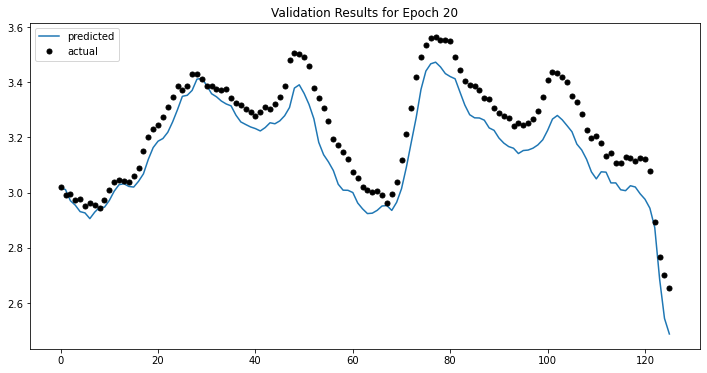

EarlyStopping counter: 2 out of 50
Iter:  21 train:  0.12189936509378146 val:  0.08512073169665244 LR:  0.01
Validation loss decreased (0.033025 --> 0.011376).  Saving model ...
Iter:  22 train:  0.1065851540436976 val:  0.048937458554749895 LR:  0.01
Validation loss decreased (0.011376 --> 0.008006).  Saving model ...
Iter:  23 train:  0.10943170719992998 val:  0.041053937001383975 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  24 train:  0.10364708337078186 val:  0.11734044244206299 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  25 train:  0.10309603155696037 val:  0.08143073838021804 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  26 train:  0.09925710460865102 val:  0.09298934631927752 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  27 train:  0.09679393059561475 val:  0.10678795794049166 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  28 train:  0.095765171068563 val:  0.05294460318727563 LR:  0.01
Validation loss decreased (0.008006 --> 0.006570).  Saving mo

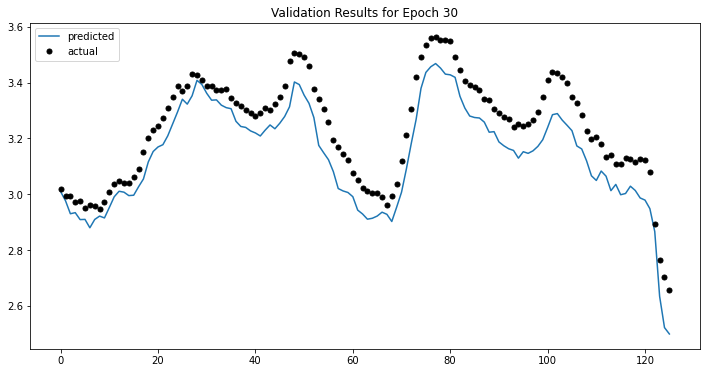

EarlyStopping counter: 2 out of 50
Iter:  31 train:  0.08417456855274684 val:  0.06020638812146088 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  32 train:  0.09484176435487089 val:  0.04673704458305015 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  33 train:  0.11390953757407331 val:  0.1170189688190297 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  34 train:  0.0884386609590511 val:  0.0672054291070636 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  35 train:  0.09149446871153928 val:  0.0942626121482253 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  36 train:  0.09939986024764591 val:  0.05159934716654102 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  37 train:  0.08823667046758689 val:  0.09503569396635712 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  38 train:  0.09133635497708338 val:  0.06397449279629387 LR:  0.01
Validation loss decreased (0.006570 --> 0.004546).  Saving model ...
Iter:  39 train:  0.08517112412798879 val:  0.03093658073826381

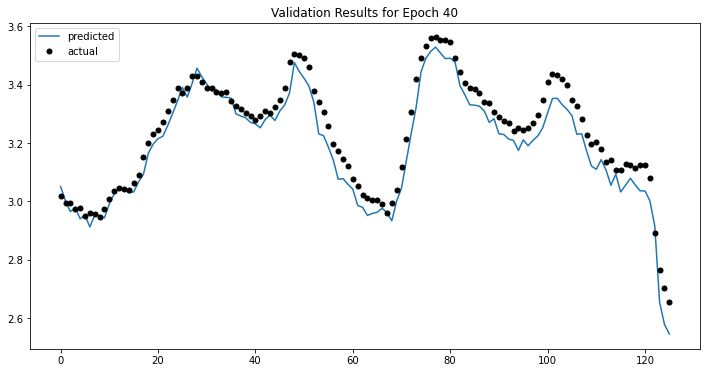

EarlyStopping counter: 2 out of 50
Iter:  41 train:  0.08825926396571443 val:  0.06924920502101271 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  42 train:  0.09572275908316877 val:  0.09912219515488475 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  43 train:  0.10551702688998027 val:  0.03950176001571613 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  44 train:  0.14369136642599173 val:  0.05862657815280418 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  45 train:  0.10475211854584024 val:  0.051370447910154424 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  46 train:  0.08915699012026254 val:  0.08131032431052003 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  47 train:  0.08443275456785095 val:  0.057271365359186414 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  48 train:  0.07989988980916003 val:  0.031191318588952716 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  49 train:  0.08039801118499093 val:  0.06650966168968725 LR:  0.01
EarlyStopping c

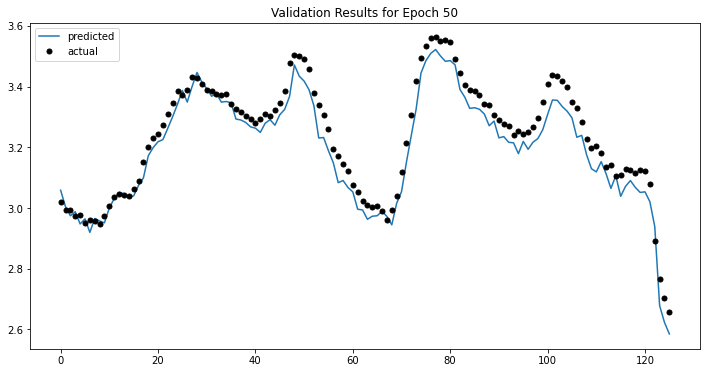

EarlyStopping counter: 12 out of 50
Iter:  51 train:  0.08185890012474646 val:  0.0734345613454459 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  52 train:  0.08473514476519571 val:  0.031589612661882184 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  53 train:  0.09045218740929378 val:  0.07191107928602576 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  54 train:  0.07851936085619944 val:  0.054836554352412706 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  55 train:  0.07795852138015529 val:  0.04920179332462714 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  56 train:  0.07435025859384631 val:  0.051851735347889776 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  57 train:  0.07348060156202249 val:  0.05321842585015043 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  58 train:  0.07580782718669475 val:  0.05216804537030578 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  59 train:  0.0737193272775914 val:  0.059376434491867545 LR:  0.001
Ear

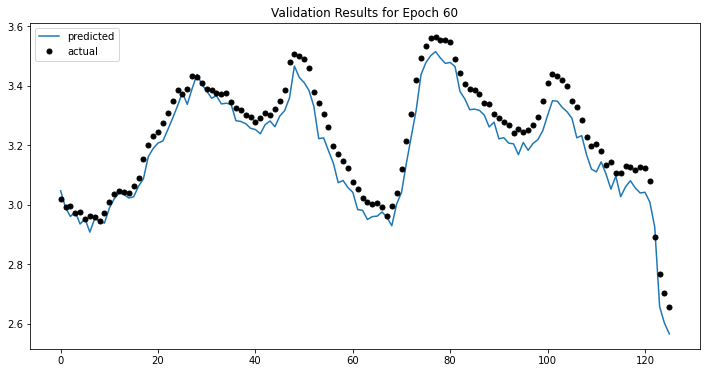

EarlyStopping counter: 22 out of 50
Iter:  61 train:  0.07400393191142163 val:  0.06356808699305941 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  62 train:  0.07426977360784862 val:  0.05876814374291506 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  63 train:  0.07437930810925025 val:  0.059209872640829976 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  64 train:  0.07386815355394198 val:  0.057429668844346166 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  65 train:  0.07325181554788712 val:  0.05421124054123435 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  66 train:  0.0737591274258081 val:  0.053924110537297044 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  67 train:  0.07321828998151093 val:  0.05550515418769595 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  68 train:  0.07411448805411831 val:  0.0638977904734658 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  69 train:  0.07341419468235018 val:  0.060157613655703976 LR:  0.001

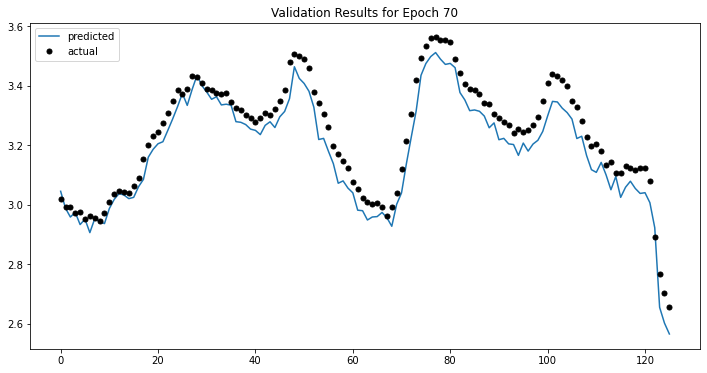

EarlyStopping counter: 32 out of 50
Iter:  71 train:  0.0736181949225532 val:  0.05507012334177351 LR:  0.0001
EarlyStopping counter: 33 out of 50
Iter:  72 train:  0.07297286804241333 val:  0.05799819482756803 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  73 train:  0.07270583972746571 val:  0.057455391011006454 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  74 train:  0.07269340624292621 val:  0.05711353422733779 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  75 train:  0.07277629672861896 val:  0.05682858893759319 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  76 train:  0.07271851360495933 val:  0.057280244186014836 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  77 train:  0.07267541792593989 val:  0.057963618658719004 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  78 train:  0.07285345592664995 val:  0.0575652736699194 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  79 train:  0.0727870026701598 val:  0.05693558629135869 LR: 

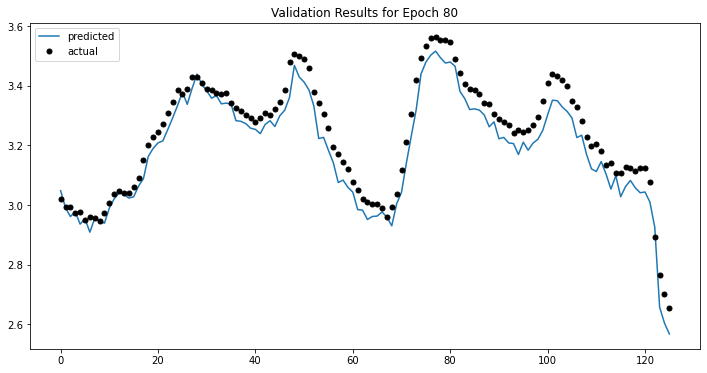

EarlyStopping counter: 42 out of 50
Iter:  81 train:  0.07285041212716056 val:  0.057395373674561594 LR:  0.0001
EarlyStopping counter: 43 out of 50
Iter:  82 train:  0.07274164589320739 val:  0.057179409414312855 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  83 train:  0.07272613084193308 val:  0.05705298512258954 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  84 train:  0.07266900158201242 val:  0.05872245083908708 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  85 train:  0.0727485350489768 val:  0.05780699363577156 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  86 train:  0.07282805885282179 val:  0.05792133729610043 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  87 train:  0.07277469791531184 val:  0.05769847470772685 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  88 train:  0.07261342813344031 val:  0.05773771665338767 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [52]:
nn_train(model=darnn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=darnn_opt, 
         scheduler=darnn_scheduler,
         target_scaler=target_scaler,
         device=device,
         plot=True)

### Evaluation

In [53]:
# Load best-performing model
darnn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

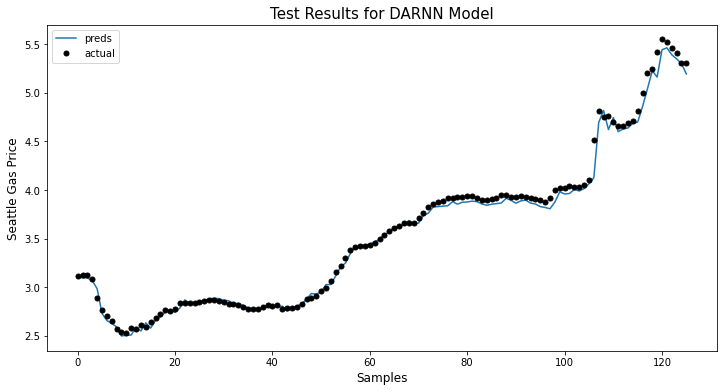

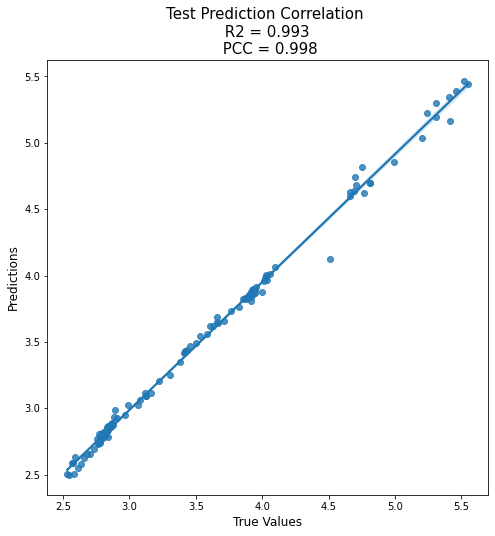

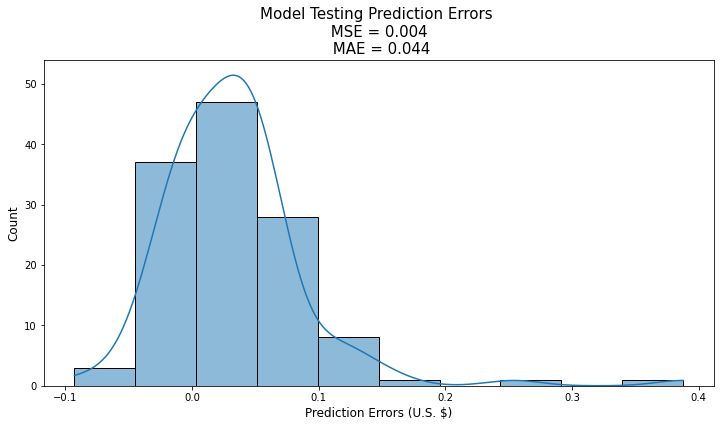

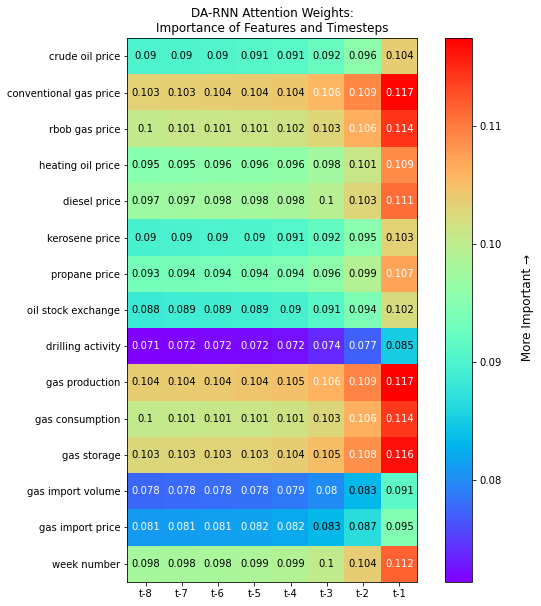

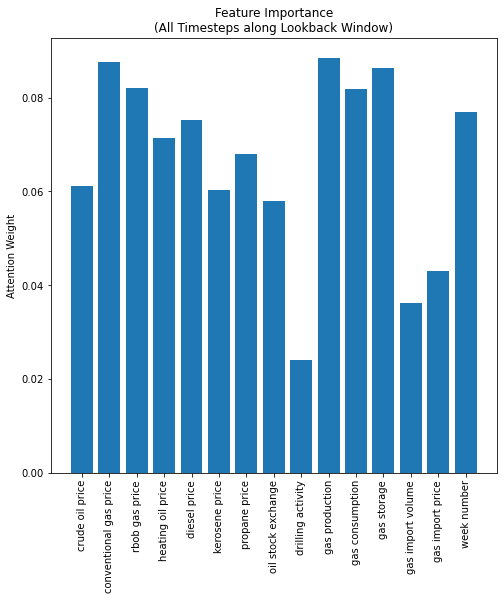

In [65]:
darnn_mse, darnn_mae, darnn_r2, darnn_pcc, darnn_preds, darnn_true, darnn_alphas, darnn_betas = nn_eval(model=darnn, 
                                                                             model_name='darnn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler, 
                                                                             device=device, 
                                                                             cols=feature_names
                                                                             )

### Forecasting

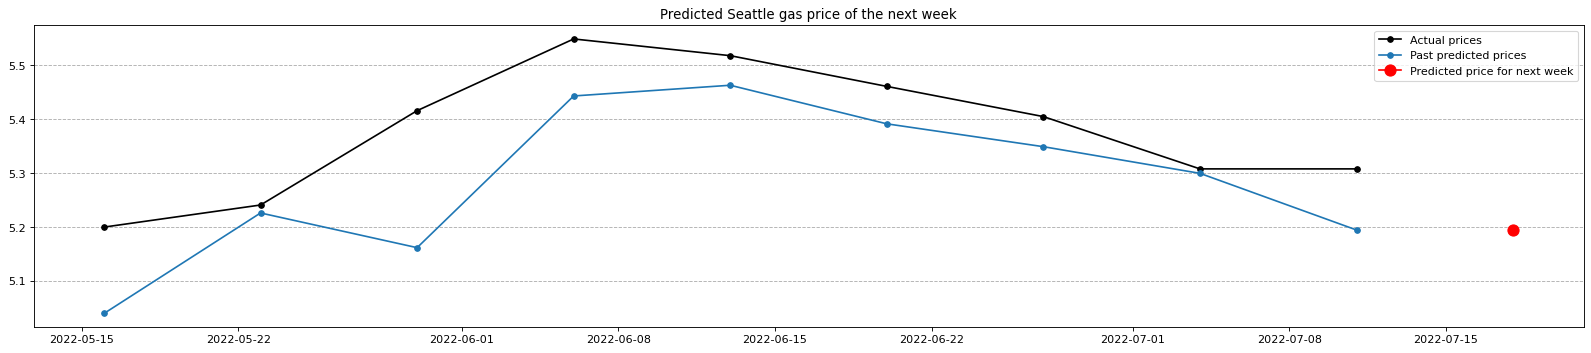

DARNN Predicted Seattle Gas Price of the next week: $5.19


In [55]:
nn_forecast(model = darnn,
            model_name = 'darnn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = darnn_true, 
            preds = darnn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler,
            device=device,
            dates=data_date, 
            plot_range=10
           )

## 5e. Hierarchical Attention-Based Recurrent Highway Network (HARHN)

### Training

In [56]:
harhn = HARHN(n_conv_layers=3, 
              T=timesteps, 
              in_feats=n_timeseries, 
              target_feats=1, 
              n_units_enc=harhn_n_enc_units, 
              n_units_dec=harhn_n_dec_units, 
              device=device
             ).to(device)
model_name = 'harhn'
harhn_opt = optim.AdamW(harhn.parameters(), lr=0.01) # optimizer
harhn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=harhn_opt, patience=15) # learning rate scheduler 

Validation loss decreased (inf --> 0.716376).  Saving model ...
Iter:  0 train:  2.72270510320828 val:  0.38835048301695213 LR:  0.01
mse:  0.15149796 mae:  0.35279915


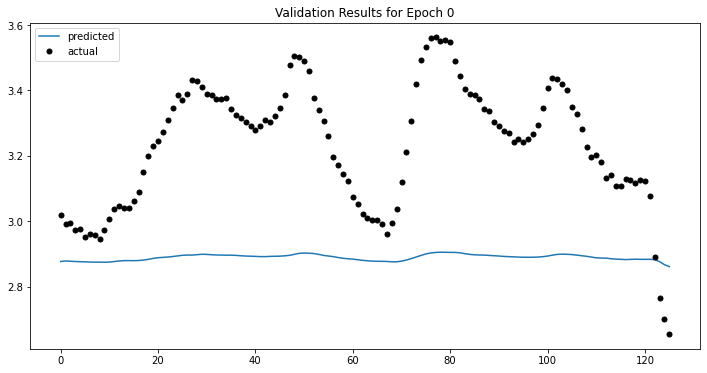

Validation loss decreased (0.716376 --> 0.333999).  Saving model ...
Iter:  1 train:  1.0492285508816561 val:  0.2651709757869305 LR:  0.01
Validation loss decreased (0.333999 --> 0.134531).  Saving model ...
Iter:  2 train:  0.5310968321350643 val:  0.16829208894413145 LR:  0.01
Validation loss decreased (0.134531 --> 0.014011).  Saving model ...
Iter:  3 train:  0.27183094839045624 val:  0.05431191162118446 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  4 train:  0.20071892225720345 val:  0.06452671687283248 LR:  0.01
Validation loss decreased (0.014011 --> 0.009234).  Saving model ...
Iter:  5 train:  0.1541857285152093 val:  0.04408980857874907 LR:  0.01
Validation loss decreased (0.009234 --> 0.007880).  Saving model ...
Iter:  6 train:  0.13537747885937843 val:  0.04073102853520688 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  7 train:  0.13393135890463212 val:  0.04500485048407103 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  8 train:  0.13626529665483433 val:  

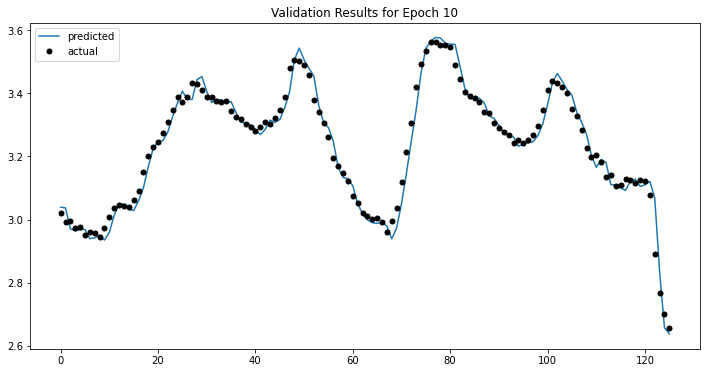

EarlyStopping counter: 1 out of 50
Iter:  11 train:  0.12461619317695882 val:  0.0470956447178027 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  12 train:  0.13969635524148552 val:  0.057760267562145196 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  13 train:  0.11363151158457453 val:  0.04788952046943963 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  14 train:  0.11058418762071416 val:  0.035731641572242276 LR:  0.01
Validation loss decreased (0.005272 --> 0.004583).  Saving model ...
Iter:  15 train:  0.11620230656664776 val:  0.031060403621669223 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  16 train:  0.11304985081142668 val:  0.03864109774257944 LR:  0.01
Validation loss decreased (0.004583 --> 0.004339).  Saving model ...
Iter:  17 train:  0.10784690809526006 val:  0.03022541967815962 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  18 train:  0.10589840487149432 val:  0.03220181949790419 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  19 train:  0.106

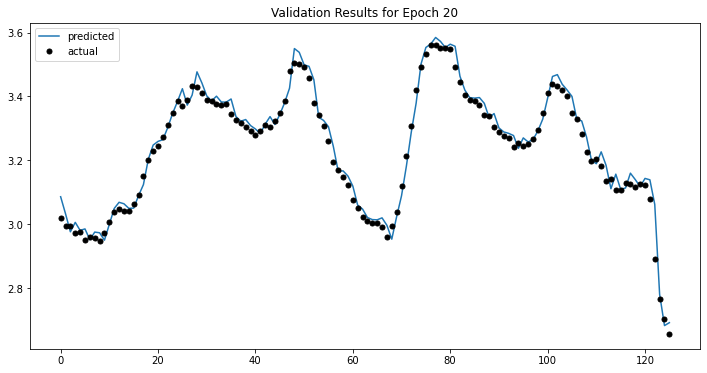

EarlyStopping counter: 4 out of 50
Iter:  21 train:  0.09561981930953137 val:  0.04034999761805218 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  22 train:  0.12228936322659345 val:  0.04239004117810812 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  23 train:  0.10878624435640039 val:  0.053100311200122916 LR:  0.01
Validation loss decreased (0.004339 --> 0.004171).  Saving model ...
Iter:  24 train:  0.09978627618161799 val:  0.02963318318319455 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  25 train:  0.10451302711827966 val:  0.032835811328900504 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  26 train:  0.0936943732864776 val:  0.03381039256383762 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  27 train:  0.0993865052295696 val:  0.039234052732647275 LR:  0.01
Validation loss decreased (0.004171 --> 0.003515).  Saving model ...
Iter:  28 train:  0.0998099379413608 val:  0.027202146355208734 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  29 train:  0.0933

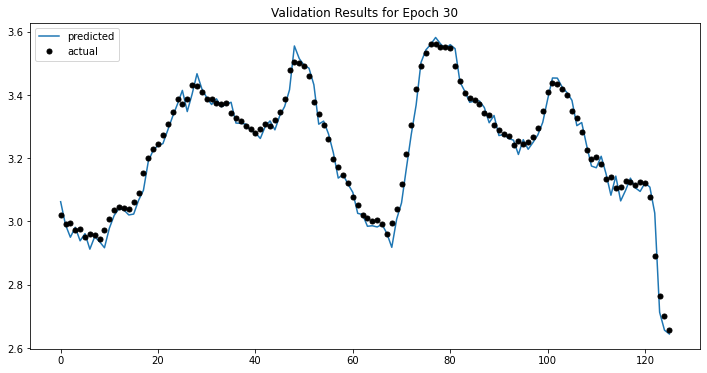

EarlyStopping counter: 3 out of 50
Iter:  31 train:  0.11889855178081495 val:  0.027915311081007314 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  32 train:  0.09881637559867061 val:  0.04069800609272879 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  33 train:  0.10215822290652254 val:  0.049501913237581144 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  34 train:  0.10585676660974529 val:  0.03650542018336455 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  35 train:  0.09249451686781743 val:  0.027537411695546424 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  36 train:  0.10445560257809466 val:  0.061640601884796746 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  37 train:  0.10323951233945361 val:  0.04596073110650214 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  38 train:  0.09607979513425842 val:  0.027949675865241653 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  39 train:  0.09829155851152573 val:  0.029540667821164962 LR:  0.01
EarlyStoppi

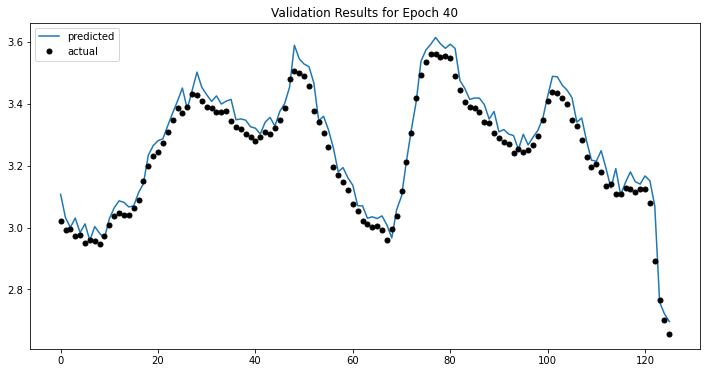

EarlyStopping counter: 13 out of 50
Iter:  41 train:  0.09711233158296372 val:  0.03789189172953049 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  42 train:  0.09947571952595582 val:  0.0276028638457975 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  43 train:  0.1047382249702508 val:  0.03011696829692629 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  44 train:  0.10419920012534765 val:  0.02843584668887537 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  45 train:  0.08868539813401269 val:  0.0283482602656531 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  46 train:  0.08656431674510351 val:  0.02772695842946628 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  47 train:  0.08716112623872886 val:  0.03029877149803224 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  48 train:  0.08711015918564043 val:  0.028604643239539627 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  49 train:  0.08703577982134786 val:  0.02829975625722807 LR:  0.001
EarlyS

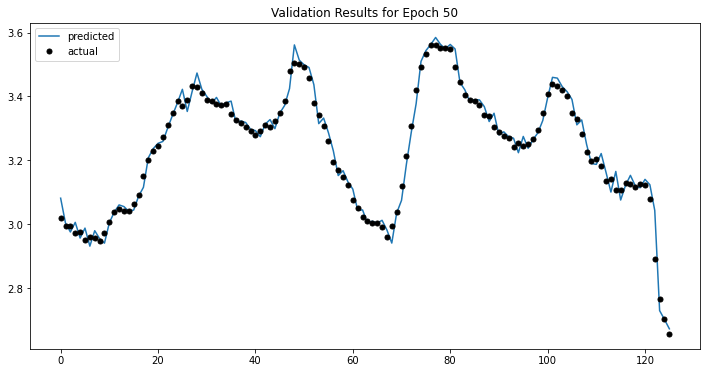

EarlyStopping counter: 23 out of 50
Iter:  51 train:  0.08595456751624117 val:  0.027680542998783118 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  52 train:  0.08623627337378342 val:  0.029358164278728123 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  53 train:  0.08959742852622812 val:  0.02796123337386822 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  54 train:  0.08907221879163006 val:  0.028521681784073674 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  55 train:  0.0892568257167579 val:  0.027771246507970703 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  56 train:  0.08583149568947791 val:  0.02772419360229667 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  57 train:  0.08820968988413226 val:  0.02949433874929048 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  58 train:  0.08578411279697472 val:  0.027801767309848843 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  59 train:  0.08711714015314478 val:  0.027657881910898387 LR:  0.

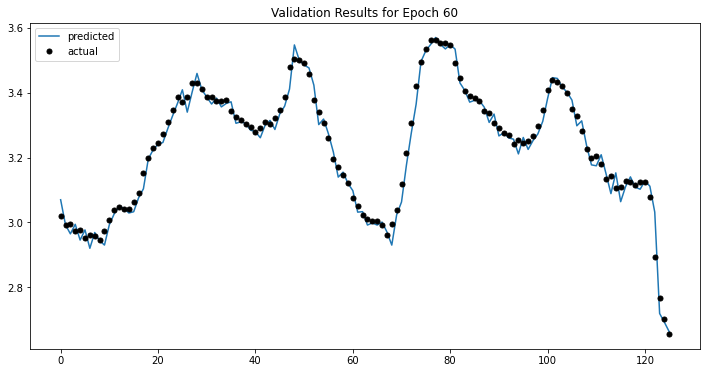

EarlyStopping counter: 33 out of 50
Iter:  61 train:  0.08574025484459667 val:  0.02804998703314759 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  62 train:  0.08540381089132235 val:  0.02761616197166444 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  63 train:  0.08526681242876313 val:  0.027712381253013084 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  64 train:  0.08522107145985695 val:  0.02767297103172353 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  65 train:  0.08521021597856385 val:  0.027633028217854967 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  66 train:  0.08532017665322297 val:  0.027675561013381728 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  67 train:  0.08529106429418375 val:  0.02760095627278409 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  68 train:  0.08519223660355987 val:  0.027855593619793735 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  69 train:  0.08537683330416798 val:  0.027686905230037626

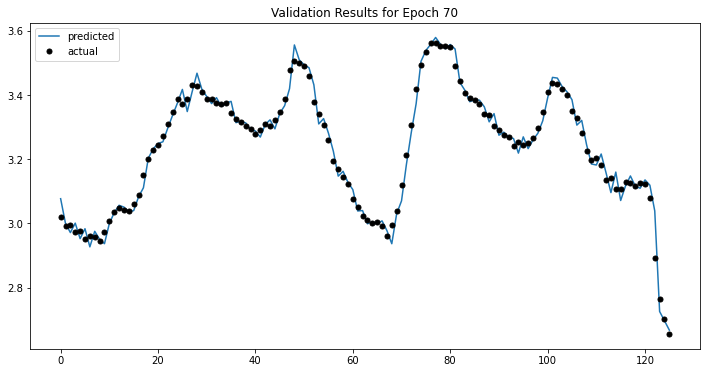

EarlyStopping counter: 43 out of 50
Iter:  71 train:  0.08525172086496131 val:  0.02764688655822997 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  72 train:  0.08550986394378049 val:  0.02779547035959015 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  73 train:  0.08559598174167776 val:  0.02760443734794147 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  74 train:  0.08554095846930333 val:  0.027583065141745036 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  75 train:  0.08528529985696921 val:  0.02776005707648644 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  76 train:  0.08538569354935834 val:  0.027833948301607844 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  77 train:  0.08519532876060697 val:  0.027741820507400802 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [57]:
nn_train(model=harhn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=harhn_opt, 
         scheduler=harhn_scheduler,
         target_scaler=target_scaler,
         device=device,
         plot=True)

### Evaluation

In [58]:
# Load best-performing model
harhn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

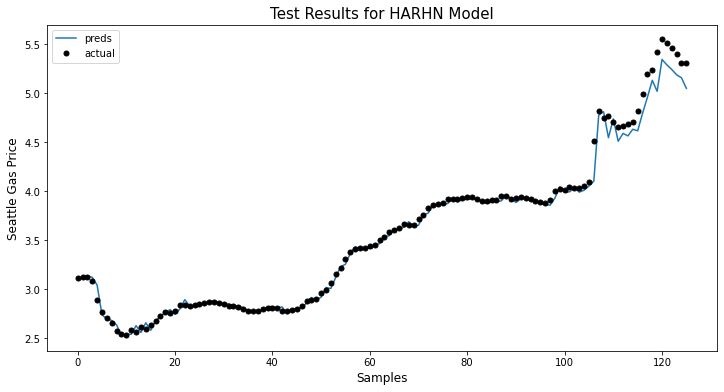

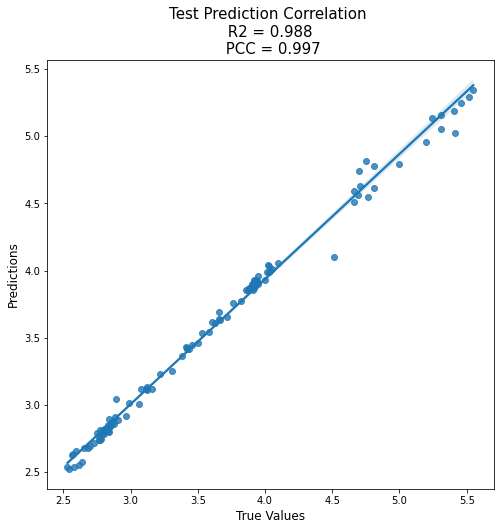

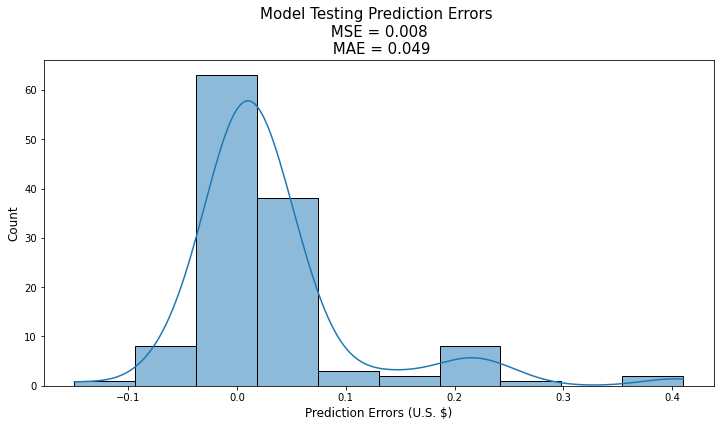

In [66]:
harhn_mse, harhn_mae, harhn_r2, harhn_pcc, harhn_preds, harhn_true, _, _ = nn_eval(model=harhn, 
                                                                             model_name='harhn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler, 
                                                                             device=device, 
                                                                             cols=feature_names
                                                                             )

### Forecast

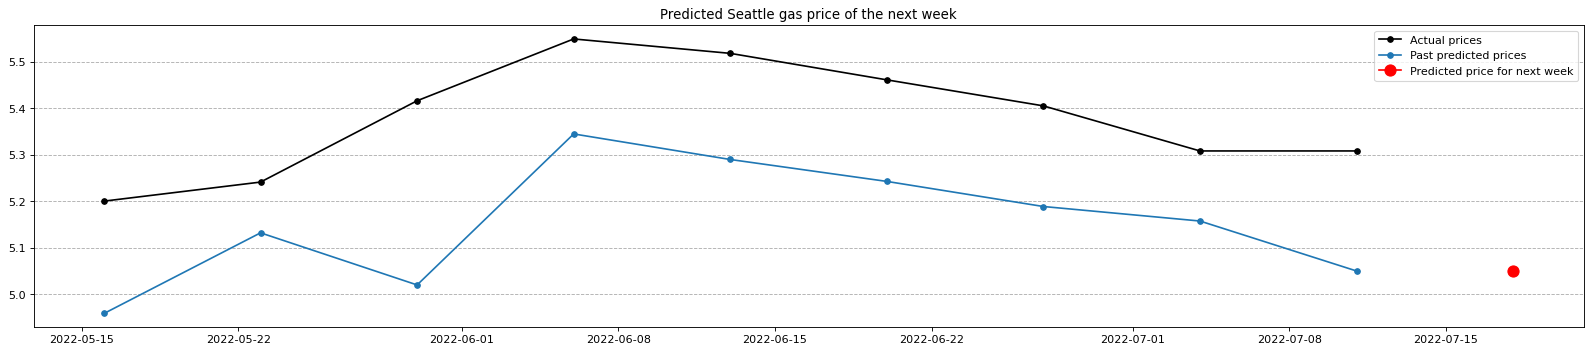

HARHN Predicted Seattle Gas Price of the next week: $5.05


In [60]:
nn_forecast(model = harhn,
            model_name = 'harhn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = harhn_true, 
            preds = harhn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            device=device,
            dates=data_date,
            plot_range=10
           )

# 6. Model Comparison

In [61]:
model_names = ['Prophet', 'Neural Prophet', 'LSTM', 'DA-RNN', 'HRHN']

df=pd.DataFrame({"Root Mean Square Err.":[prophet_mse**0.5, nprophet_mse**0.5, lstm_mse**0.5, darnn_mse**0.5, harhn_mse**0.5],
                 "Mean Absolute Err.":[prophet_mae, nprophet_mae, lstm_mae, darnn_mae, harhn_mae], 
                 "R2 Score": [prophet_r2, nprophet_r2, lstm_r2, darnn_r2, harhn_r2], 
                 "Pearson Corr. Coeff.": [prophet_pcc, nprophet_pcc, lstm_pcc, darnn_pcc, harhn_pcc]
                })
df = df.round(decimals=3)
df.index = model_names

df = df.style.highlight_max(
    subset = ['R2 Score', 'Pearson Corr. Coeff.'],
    color = 'lightgreen', axis = 0).highlight_min(
    subset = ['Root Mean Square Err.', 'Mean Absolute Err.'],
    color = 'lightgreen', axis = 0)

In [62]:
df

,Root Mean Square Err.,Mean Absolute Err.,R2 Score,Pearson Corr. Coeff.
Prophet,0.650000,0.517000,0.220000,0.518000
Neural Prophet,0.693000,0.571000,0.114000,0.718000
LSTM,0.334000,0.269000,0.828000,0.969000
DA-RNN,0.065000,0.044000,0.993000,0.998000
HRHN,0.088000,0.049000,0.988000,0.997000
